#**BERT finetuning 실습자료**


Google colab 환경에 맞게 최적화

[Reference]

1.
한국어 BERT언어모델

 1. [https://aclanthology.org/N19-1423.pdf](https://aclanthology.org/N19-1423.pdf)
 2. [SKTBrain BERT](https://github.com/SKTBrain/KoBERT)
 3. [https://complexoftaste.tistory.com/2#comment17329839](https://complexoftaste.tistory.com/2#comment17329839)
 4. [https://hoit1302.tistory.com/159](https://hoit1302.tistory.com/159)


2.
NSMC 네이버 영화리뷰 데이터셋
 - [https://github.com/e9t/nsmc](https://github.com/e9t/nsmc)

##기초 내용 다지기

###BERT에서 가장 중요한 기본 구조 PFA(Pretraining & Finetuning Approach)

- 대용량의 데이터로 사전학습된 파라미터를 토대로 다양한 Downstream task에 적용시키는 방식

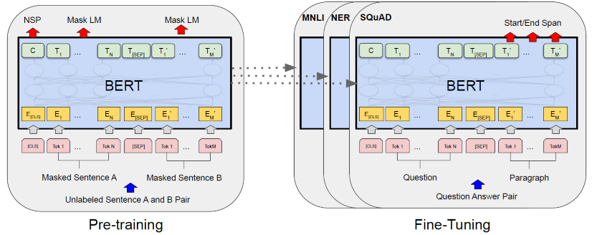

과정은 크게 2가지로 분류


*   사전학습을 직접 수행할 것인가? (수십~수백 GB 방대한 양의 데이터 & 학습 가능한 리소스가 준비되었는가?)

**OR**

*   사전학습이 잘 된 모델을 호출하여 내가 원하는 도메인에 적용시킬 것인가?



### Downstream Task 선정

* 내가 BERT 모델(Transformer 인코더 구조)을 활용하여 어떤 Task 를 해결하고자 하는가?
* 왜 이 Task를 해결하고자 하는가?

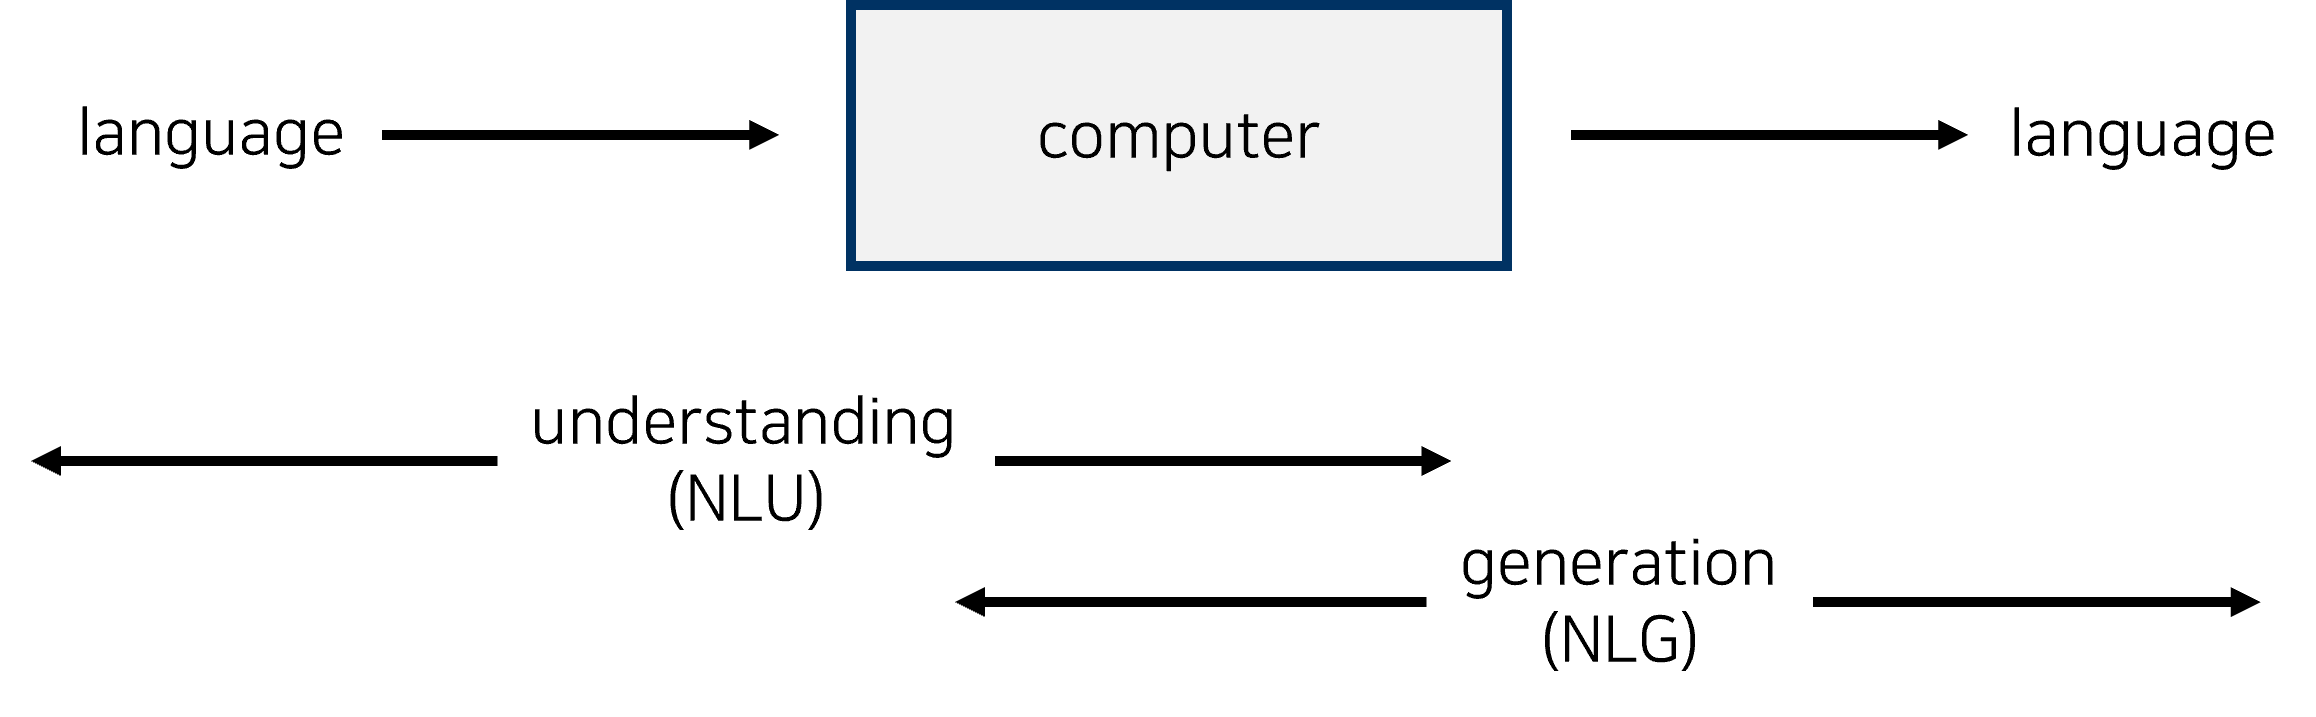

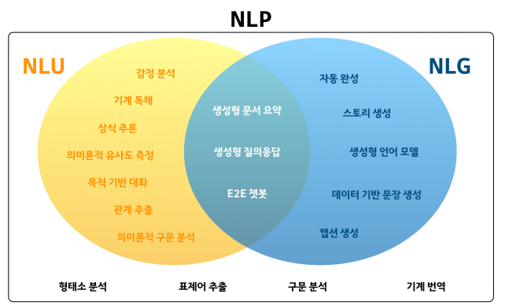

(https://woongsin94.tistory.com/341)

* NLP에는 어떤 Task가 있는가? (아래 표는 NLU 위주)

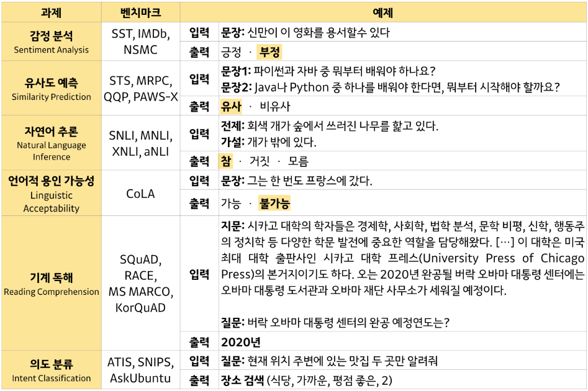

## BERT 학습 순서



1.   환경 세팅(GPU 사용 필수! - CPU 로 가능한 연산 수준이 아님)
2.   데이터 세팅 및 토크나이저 초기화
3.   PLM(Pre-trained Language Model) - 사전학습된 언어모델 호출 및 모델 초기화
4.   입력 값 생성 및 BERT 학습
5.   모델 성능 평가 및 모델 저장


## 한국어 BERT 모델을 활용한 네이버 영화리뷰(Naver Sentiment Movie Corpus, NSMC) 감정분석 모델을 학습

### 1. 데이터 분석


* 15만 개의 train 데이터, 5만 개의 test 데이터로 구성
* 일부 데이터가 NaN, 중복 데이터 존재

\\
* 3개의 컬럼으로 구성: {id, document, label}
* label이 1일 경우 긍정
* label이 0일 경우 부정

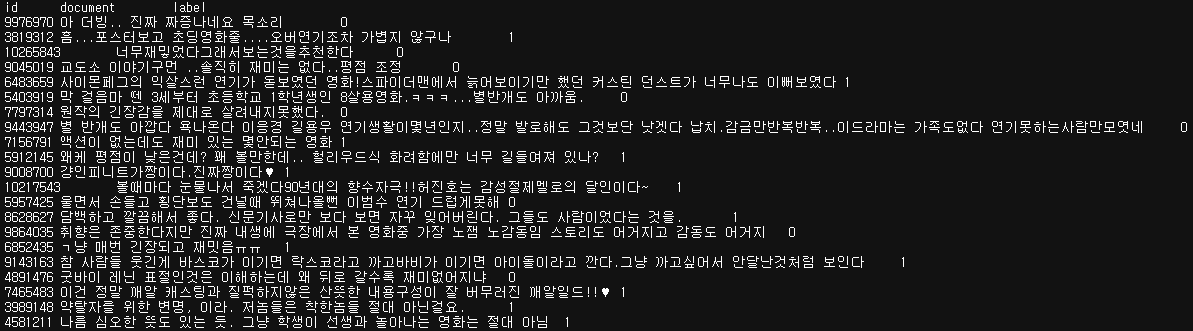

In [1]:
!pip install transformers    # Hugginface transformers 설치
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292695 sha256=a0b492f0825f56a3f90ea31f7660e74ff23f4fd75f913a02ee598383ae854b18
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00


In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-tzqnqoe2/kobert-tokenizer_251a74f24cbe428991d82fa612dc5ef0
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-tzqnqoe2/kobert-tokenizer_251a74f24cbe428991d82fa612dc5ef0
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=7486d65cde996db71e8a92ad01350fa0219d6d3a5b088851fafe0b1a06dcd8ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tp25m89/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [3]:
# NSMC 데이터셋 다운로드
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2023-11-29 16:16:06--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.08s   

2023-11-29 16:16:07 (59.1 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]

--2023-11-29 16:16:07--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to

**데이터셋 체크**

In [4]:
!head ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


In [5]:
!head ratings_test.txt

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0


### 필요한 기초 라이브러리 함수 호출

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gluonnlp as nlp
from torch.utils.data import DataLoader, Dataset

# from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm.notebook import tqdm

import numpy as np
import random

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


### 동일한 결과 출력을 위한 랜덤시드 고정

In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##SKTbrain KoBERT의 토크나이저 & 모델 호출

In [8]:
# GPU를 사용할 것이므로, CUDA 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# KoBERT 토크나이저 & 모델
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

- 하이퍼파라미터 세팅

In [10]:
# Setting parameters
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

### 데이터셋 호출 및 입력데이터 토크나이징

In [11]:
dataset_train = nlp.data.TSVDataset("ratings_train.txt", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("ratings_test.txt", field_indices=[1,2], num_discard_samples=1)

### BERTSentenceTransform 데이터 입력 클래스 정의

In [12]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'), np.array(segment_ids, dtype='int32')



###사용자 정의 클래스 BERTDataset 생성

Dataset 클래스엔 다음의 3개의 함수를 같이 구현

- \_\__init\_\__ : 객체 실행시 1번 실행 및 초기화
- \_\__len\_\__  : 데이터셋의 샘플 개수 반환
- \_\__getitem\_\__ : 주어진 인덱스(i) 에 해당하는 샘플을 데이터셋에서 불러오고 반환함. 인덱스를 기반으로 해당 텍스트 데이터의 위치 식별 및 sentences, labels를 가져옴





In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [14]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

### DataLoader

DataLoader로 데이터를 불러와 데이터셋을 반복적으로 iterate 하면서 불러올 수 있음

해당 데이터는 batch 단위로 반환

In [15]:
train_dataloader = DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 분류를 위한 BERTClassifier 클래스 정의

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

### 학습 파라미터 세팅

In [18]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


최종 연산 매트릭(accuracy)

In [19]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

## 모델 학습 수행

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    model.train()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        pred = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(pred, label)
        # loss F.cross_entropy(pred, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(pred, label)

        if batch_id % log_interval == 0:
            print("Epoch: {} batch id: {} loss: {} train acc: {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

    print("Epoch: {} train acc: {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        pred = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(pred, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/4688 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 batch id: 1 loss: 0.6601355671882629 train acc: 0.65625
Epoch: 1 batch id: 201 loss: 0.706011176109314 train acc: 0.5206778606965174
Epoch: 1 batch id: 401 loss: 0.45547938346862793 train acc: 0.6069201995012469
Epoch: 1 batch id: 601 loss: 0.46332526206970215 train acc: 0.6647254575707154
Epoch: 1 batch id: 801 loss: 0.29066047072410583 train acc: 0.7051732209737828
Epoch: 1 batch id: 1001 loss: 0.4117780327796936 train acc: 0.7306443556443556
Epoch: 1 batch id: 1201 loss: 0.4511796236038208 train acc: 0.7500260199833472
Epoch: 1 batch id: 1401 loss: 0.4893088638782501 train acc: 0.7632940756602427
Epoch: 1 batch id: 1601 loss: 0.4068101942539215 train acc: 0.7748282323547783
Epoch: 1 batch id: 1801 loss: 0.6695050597190857 train acc: 0.7833842309827873
Epoch: 1 batch id: 2001 loss: 0.2012273520231247 train acc: 0.7899956271864068
Epoch: 1 batch id: 2201 loss: 0.2602759301662445 train acc: 0.7967117219445706
Epoch: 1 batch id: 2401 loss: 0.11467094719409943 train acc: 0.80174

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 1 test acc 0.8806381957773513


  0%|          | 0/4688 [00:00<?, ?it/s]

Epoch: 2 batch id: 1 loss: 0.2682119607925415 train acc: 0.84375
Epoch: 2 batch id: 201 loss: 0.19122692942619324 train acc: 0.9028296019900498
Epoch: 2 batch id: 401 loss: 0.27114900946617126 train acc: 0.9012624688279302
Epoch: 2 batch id: 601 loss: 0.26774778962135315 train acc: 0.8994904326123128
Epoch: 2 batch id: 801 loss: 0.193805530667305 train acc: 0.9003199126092385
Epoch: 2 batch id: 1001 loss: 0.31642240285873413 train acc: 0.9010364635364635
Epoch: 2 batch id: 1201 loss: 0.23935715854167938 train acc: 0.9013322231473772
Epoch: 2 batch id: 1401 loss: 0.16838662326335907 train acc: 0.9012089578872234
Epoch: 2 batch id: 1601 loss: 0.19935378432273865 train acc: 0.9008237039350406
Epoch: 2 batch id: 1801 loss: 0.29422909021377563 train acc: 0.8998820099944476
Epoch: 2 batch id: 2001 loss: 0.051399361342191696 train acc: 0.900534107946027
Epoch: 2 batch id: 2201 loss: 0.1579744517803192 train acc: 0.9007979327578374
Epoch: 2 batch id: 2401 loss: 0.22943079471588135 train acc: 0

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 2 test acc 0.894593730006398


  0%|          | 0/4688 [00:00<?, ?it/s]

Epoch: 3 batch id: 1 loss: 0.07141213864088058 train acc: 1.0
Epoch: 3 batch id: 201 loss: 0.15634162724018097 train acc: 0.9364116915422885
Epoch: 3 batch id: 401 loss: 0.23784291744232178 train acc: 0.9364089775561097
Epoch: 3 batch id: 601 loss: 0.17367242276668549 train acc: 0.9370320299500832
Epoch: 3 batch id: 801 loss: 0.10618288069963455 train acc: 0.9382802746566792
Epoch: 3 batch id: 1001 loss: 0.15110287070274353 train acc: 0.9373126873126874
Epoch: 3 batch id: 1201 loss: 0.06262917816638947 train acc: 0.9374479600333055
Epoch: 3 batch id: 1401 loss: 0.1275855153799057 train acc: 0.937410778015703
Epoch: 3 batch id: 1601 loss: 0.06813126057386398 train acc: 0.9368558713304185
Epoch: 3 batch id: 1801 loss: 0.05427864193916321 train acc: 0.9368579955580233
Epoch: 3 batch id: 2001 loss: 0.1781027913093567 train acc: 0.936609820089955
Epoch: 3 batch id: 2201 loss: 0.13620233535766602 train acc: 0.9361795774647887
Epoch: 3 batch id: 2401 loss: 0.21003374457359314 train acc: 0.936

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 3 test acc 0.8998320537428023


  0%|          | 0/4688 [00:00<?, ?it/s]

Epoch: 4 batch id: 1 loss: 0.32789382338523865 train acc: 0.90625
Epoch: 4 batch id: 201 loss: 0.13941258192062378 train acc: 0.9656405472636815
Epoch: 4 batch id: 401 loss: 0.2630401849746704 train acc: 0.9677369077306733
Epoch: 4 batch id: 601 loss: 0.012749597430229187 train acc: 0.9677100665557404
Epoch: 4 batch id: 801 loss: 0.021850116550922394 train acc: 0.9684378901373284
Epoch: 4 batch id: 1001 loss: 0.1277138888835907 train acc: 0.9675949050949051
Epoch: 4 batch id: 1201 loss: 0.025739410892128944 train acc: 0.9675010407993339
Epoch: 4 batch id: 1401 loss: 0.1816377192735672 train acc: 0.967121698786581
Epoch: 4 batch id: 1601 loss: 0.22512005269527435 train acc: 0.9674227045596502
Epoch: 4 batch id: 1801 loss: 0.2520598769187927 train acc: 0.9673792337590228
Epoch: 4 batch id: 2001 loss: 0.10740653425455093 train acc: 0.9670321089455273
Epoch: 4 batch id: 2201 loss: 0.017154986038804054 train acc: 0.96710302135393
Epoch: 4 batch id: 2401 loss: 0.027052266523241997 train acc:

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 4 test acc 0.8977327255278311


  0%|          | 0/4688 [00:00<?, ?it/s]

Epoch: 5 batch id: 1 loss: 0.03171839937567711 train acc: 1.0
Epoch: 5 batch id: 201 loss: 0.003316673683002591 train acc: 0.9816542288557214
Epoch: 5 batch id: 401 loss: 0.22820504009723663 train acc: 0.9817643391521197
Epoch: 5 batch id: 601 loss: 0.03659660741686821 train acc: 0.9815931780366056
Epoch: 5 batch id: 801 loss: 0.024960989132523537 train acc: 0.9814294631710362
Epoch: 5 batch id: 1001 loss: 0.1517489105463028 train acc: 0.9817682317682318
Epoch: 5 batch id: 1201 loss: 0.006798812188208103 train acc: 0.981968151540383
Epoch: 5 batch id: 1401 loss: 0.008770802989602089 train acc: 0.9815756602426838
Epoch: 5 batch id: 1601 loss: 0.1503733992576599 train acc: 0.9818472829481574
Epoch: 5 batch id: 1801 loss: 0.005722047761082649 train acc: 0.9820065241532482
Epoch: 5 batch id: 2001 loss: 0.016767006367444992 train acc: 0.9818372063968016
Epoch: 5 batch id: 2201 loss: 0.00854078121483326 train acc: 0.9816986597001363
Epoch: 5 batch id: 2401 loss: 0.006969920825213194 train ac

  0%|          | 0/1563 [00:00<?, ?it/s]

epoch 5 test acc 0.8972728726807422


### 학습된 모델 저장 및 호출하여 Inference 해보기

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
%cd '/content/drive/MyDrive/DATA410'

/content/drive/MyDrive/DATA410


In [22]:
# model_save_path = "kobert_nsmc_model.pt"
# torch.save(model.state_dict(), model_save_path)

In [23]:
dataset_test = nlp.data.TSVDataset('naver_shopping.txt', field_indices=[1, 0])

In [24]:
naver_shopping = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)
shopping_dataloader = DataLoader(naver_shopping, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
model.load_state_dict(torch.load("kobert_nsmc_model.pt"), strict=False)
model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

네이버 쇼핑 데이터셋은 label이 1, 2, 3, 4, 5로 이루어져 있다. (그러나 실제 데이터에 3은 존재하지 않음.)

그러나 우리가 훈련한 모델은 긍정 또는 부정으로만 예측할 수 있다.

따라서 3(4) 이상을 긍정, 2 이하를 부정으로 간주하고 예측을 진행한다.

In [26]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [27]:
test_acc = 0.0
temp_acc = 0.0
all_labels = []
all_preds = []

model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(shopping_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    pred = model(token_ids, valid_length, segment_ids)

    acc = calc_accuracy(pred, (label >= 3)) # 3 이상을 긍정, 2 이하를 부정으로 간주
    test_acc += acc
    temp_acc += acc

    all_labels.extend(label.cpu().numpy())
    all_preds.extend(pred.argmax(dim=1).cpu().numpy())

    if (batch_id + 1) % 50 == 0:
        print(f"Step {batch_id + 1} Accuracy: {temp_acc / 50:.2f}")
        temp_acc = 0.0

print(f"Test Accuracy: {test_acc / (batch_id + 1):.2f}")

  0%|          | 0/6250 [00:00<?, ?it/s]

Step 50 Accuracy: 0.84
Step 100 Accuracy: 0.83
Step 150 Accuracy: 0.85
Step 200 Accuracy: 0.85
Step 250 Accuracy: 0.84
Step 300 Accuracy: 0.84
Step 350 Accuracy: 0.84
Step 400 Accuracy: 0.85
Step 450 Accuracy: 0.85
Step 500 Accuracy: 0.84
Step 550 Accuracy: 0.86
Step 600 Accuracy: 0.86
Step 650 Accuracy: 0.84
Step 700 Accuracy: 0.83
Step 750 Accuracy: 0.84
Step 800 Accuracy: 0.84
Step 850 Accuracy: 0.85
Step 900 Accuracy: 0.85
Step 950 Accuracy: 0.85
Step 1000 Accuracy: 0.85
Step 1050 Accuracy: 0.84
Step 1100 Accuracy: 0.85
Step 1150 Accuracy: 0.87
Step 1200 Accuracy: 0.85
Step 1250 Accuracy: 0.84
Step 1300 Accuracy: 0.85
Step 1350 Accuracy: 0.86
Step 1400 Accuracy: 0.85
Step 1450 Accuracy: 0.84
Step 1500 Accuracy: 0.83
Step 1550 Accuracy: 0.84
Step 1600 Accuracy: 0.84
Step 1650 Accuracy: 0.85
Step 1700 Accuracy: 0.85
Step 1750 Accuracy: 0.84
Step 1800 Accuracy: 0.85
Step 1850 Accuracy: 0.83
Step 1900 Accuracy: 0.85
Step 1950 Accuracy: 0.85
Step 2000 Accuracy: 0.84
Step 2050 Accuracy: 

전체 label의 개수는 Positive와 Negative가 아주 균등하게 분포해 있는 편이다. 예측된 label 또한 균등하게 분포해 있다.

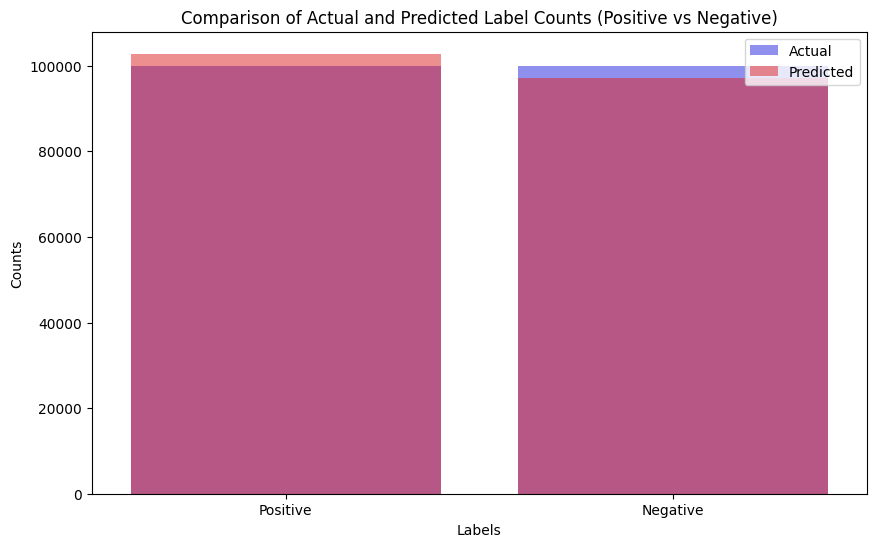

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

all_labels = ['Positive' if label >= 3 else 'Negative' for label in all_labels]
all_preds = ['Positive' if label >= 1 else 'Negative' for label in all_preds]

label_counts = [all_labels.count('Positive'), all_labels.count('Negative')]
pred_counts = [all_preds.count('Positive'), all_preds.count('Negative')]

plt.figure(figsize=(10, 6))
sns.barplot(x=['Positive', 'Negative'], y=label_counts, color='blue', alpha=0.5, label='Actual')
sns.barplot(x=['Positive', 'Negative'], y=pred_counts, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Comparison of Actual and Predicted Label Counts (Positive vs Negative)')
plt.legend()
plt.show()

최종 정확도($TP+TN$)는 84.6%이다. 분할표를 원 그래프로 시각화한 결과는 다음과 같다.

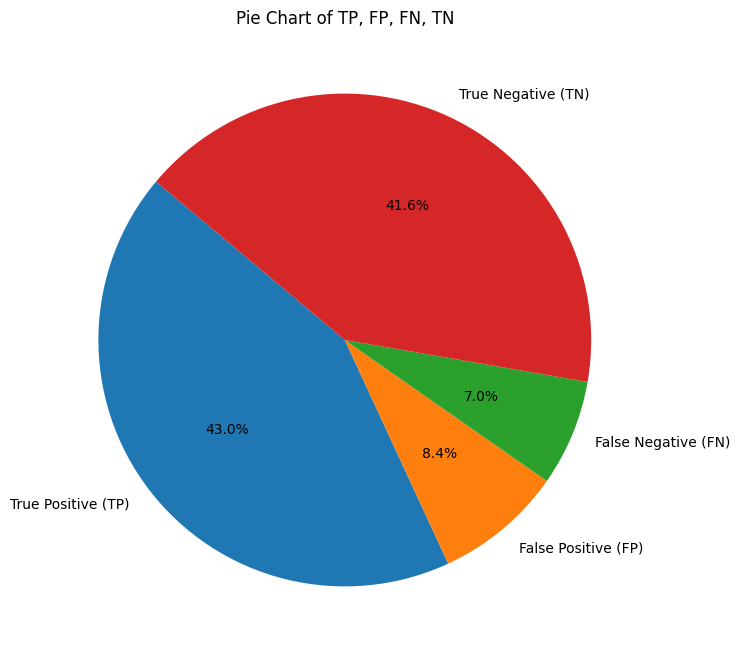

In [30]:
TP = sum(l == 'Positive' and p == 'Positive' for l, p in zip(all_labels, all_preds))
FP = sum(l == 'Negative' and p == 'Positive' for l, p in zip(all_labels, all_preds))
FN = sum(l == 'Positive' and p == 'Negative' for l, p in zip(all_labels, all_preds))
TN = sum(l == 'Negative' and p == 'Negative' for l, p in zip(all_labels, all_preds))

labels = ['True Positive (TP)', 'False Positive (FP)', 'False Negative (FN)', 'True Negative (TN)']
sizes = [TP, FP, FN, TN]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of TP, FP, FN, TN')
plt.show()